In [49]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

####################################################################################
city_len = 1860
ex_flg = False
####################################################################################

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
pop_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
msk_dir = f'{h08dir}/global_city/dat/vld_cty_'
cnt_dir = f'{h08dir}/global_city/dat/cty_cnt_/gpw4'
prf_dir = f'{h08dir}/global_city/dat/cty_prf_'

rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
pop = np.fromfile(pop_path, dtype='float32').reshape(2160, 4320)
rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)
rivara = np.fromfile(rivara_path, dtype='float32').reshape(2160, 4320)

lonlat_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/WUP2018_300k_2010.txt'
with open(lonlat_path, "r") as input_file:
    lines = input_file.readlines()

# identifying same rivnum cities into list?
city_basins = {}
for i in range(city_len):
    city_num = i+1
    ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'

    if not os.path.exists(prf_path):
        print(f'{city_num} is invalid prf')

    else:
        ctymsk = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        rivnum_mask = np.ma.masked_where(prf == 0, rivnum_gl5)
        rivnum_lst = np.unique(rivnum_mask)[:-1]
        city_basins[city_num] = rivnum_lst.filled(1e20)
        
        #largest_rivnum = np.min(rivnum_mask)
        #mask = (rivnum == largest_rivnum)
        #print('rivnum', city_num, largetst_rivnum)
        print(f'{city_num} done')

print(city_basins)

"""
basin_to_cities = {}
for city, basins in city_basins.items():
    for rivnum in basins:
        if rivnum not in basin_to_cities:
            basin_to_cities[rivnum] = []
        basin_to_cities[rivnum].append(city)

# 集計結果を出力
for rivnum, cities in basin_to_cities.items():
    if len(cities) > 1:  # 複数の都市に共有されている流域番号のみ表示
        print(f"rivnum {rivnum}: {cities}")

import json
city_basins_list = {city: basins.tolist() for city, basins in city_basins.items()}
cityrivnum = f'{h08dir}/global_city/dat/riv_num_/city_basins.json'
with open(cityrivnum, 'w') as json_file:
    json.dump(city_basins_list, json_file)
print(f'{cityrivnum} saved')
"""

1 done
2 done


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f26d03b32b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [167]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
def lonlat2xy(loncnt, latcnt, a=2160, b=4320):
    if -180 <= loncnt <=180:
        lon_middle = int(((loncnt+180)/360)*b )
        lat_middle = int(((90-latcnt)/180)*a ) 
    else:
        lon_middle = 1e20
        lat_middle = 1e20
    return lon_middle, lat_middle

################################################################################
# load files
################################################################################

# rivnxl in xy coord
riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)
riv_nxlonlat_cropped[0].shape

# basin at each city
cityrivnum = f'{h08dir}/global_city/dat/riv_num_/city_basins.json'
with open(cityrivnum, 'r') as json_file:
    city_basins = json.load(json_file)
print(len(city_basins.keys()))

# cities at same basin
basin_to_cities = {}
for city, basins in city_basins.items():
    for rivnum in basins:
        if rivnum not in basin_to_cities:
            basin_to_cities[rivnum] = []
        basin_to_cities[rivnum].append(city)
        
for rivnum, cities in basin_to_cities.items():
    if len(cities) > 1:  # 複数の都市に共有されている流域番号のみ表示
        print(f"rivnum {rivnum}: {cities}")
        
new_basin_to_cities = {rivnum: cities for rivnum, cities in basin_to_cities.items() if len(cities) > 1}

1553
rivnum 848.0: ['1', '936', '1283', '1400']
rivnum 14.0: ['2', '11', '126', '130', '133', '188', '197', '217', '243', '319', '321', '363', '406', '455', '463', '473', '513', '526', '588', '667', '669', '673', '677', '797', '883', '903', '941', '983', '1012', '1018', '1067', '1089', '1181', '1216', '1253', '1288', '1298', '1337', '1365', '1371', '1381', '1422', '1575', '1578', '1620', '1652', '1656', '1668', '1697', '1712', '1718', '1824']
rivnum 480.0: ['3', '52', '85', '144', '160', '612', '618', '967', '1200', '1299', '1376', '1687']
rivnum 5438.0: ['3', '85']
rivnum 164.0: ['4', '537', '933']
rivnum 5.0: ['5', '94', '119', '140', '155', '196', '257', '343', '550', '597', '629', '689', '789', '803', '836', '837', '866', '1235', '1327', '1329', '1361', '1411', '1453', '1500', '1530', '1573', '1648', '1720']
rivnum 4.0: ['9', '71', '200', '579', '691', '746', '1551', '1579', '1667', '1675', '1676', '1747']
rivnum 172.0: ['10', '183', '334', '386', '910', '1265', '1439']
rivnum 1124

In [176]:
def updown(new_basin_to_cities, key_index=0):
    # get uid and city list
    keys_list = list(new_basin_to_cities.keys())
    uid = keys_list[key_index]
    print(f'uid: {uid}')
    rivnum_list = new_basin_to_cities[uid]
    rivnum_list = [int(i) for i in rivnum_list]
    
    # remove overlap
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    rivnum_list_removed = [num for num in rivnum_list if num not in numbers]
    rivnum_list_removed = [int(i) for i in rivnum_list_removed]
    print('cities in uid')
    print(rivnum_list_removed)
    
    # coord of purficication
    coords_a = []
    for city_num in rivnum_list_removed:
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        prf_coord = np.where((prf == 1) & (rivnum_gl5 == uid))
        coords_a.append(prf_coord)
    #print(coords_a)
    
    # down??
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    for cid in range(len(coords_a)):
        visited_coords = set()
        riv_path_array[coords_a[cid][0][0], coords_a[cid][1][0]] = cid
        
        coords_b = coords_a.copy()
        coords_b.pop(cid) 
        cind_list = rivnum_list_removed.copy()
        cind_list.pop(cid)
        
        if len(coords_a) > 0:
            target_coord = (coords_a[cid][0][0], coords_a[cid][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = cid
                target_coord = next_coord
        
        for cind, coord in enumerate(coords_b):
            standard_coord = (coord[0][0], coord[1][0])
            if standard_coord in visited_coords:
                #print(f"upstream: city{rivnum_list_removed[cid]}, downstream: city{cind_list[cind]}")
                edges.append((rivnum_list_removed[cid], cind_list[cind]))
            #else:
                #print("no city in downstream")

    return edges, riv_path_array

In [ ]:
from collections import defaultdict, deque

updown_dict = {}
keys_list = list(new_basin_to_cities.keys())
for  key_index in range(len(keys_list)):
    uid = keys_list[key_index]
    edges, riv_path_array = updown(new_basin_to_cities, key_index=key_index)
    
    # 都市間の流れを構築
    graph = defaultdict(list)
    indegree = defaultdict(int)
    nodes = set()
    
    for upstream, downstream in edges:
        graph[upstream].append(downstream)
        indegree[downstream] += 1
        nodes.add(upstream)
        nodes.add(downstream)
    
    # トポロジカルソート
    queue = deque([node for node in nodes if indegree[node] == 0])
    sorted_order = []
    
    while queue:
        node = queue.popleft()
        sorted_order.append(node)
        
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)
    updown_dict[uid] = sorted_order
    print("Sorted order of cities from upstream to downstream:", updown_dict[uid])

uid: 848.0
cities in uid
[1, 936, 1283]
Sorted order of cities from upstream to downstream: [1283, 1]
uid: 14.0
cities in uid
[2, 11, 126, 130, 133, 188, 197, 217, 243, 319, 321, 363, 406, 455, 463, 473, 513, 526, 588, 667, 669, 673, 677, 797, 883, 903, 941, 983, 1012, 1018, 1067, 1089, 1181, 1216, 1253, 1288, 1298, 1337, 1365, 1371, 1422, 1578, 1620, 1652, 1656, 1697, 1712, 1718, 1824]


[1, 936, 1283]
[(array([646]), array([3836])), (array([639]), array([3838])), (array([644]), array([3829]))]
not city in downstream
not city in downstream
not city in downstream
not city in downstream
upstream: city1283, downstream: city1
not city in downstream


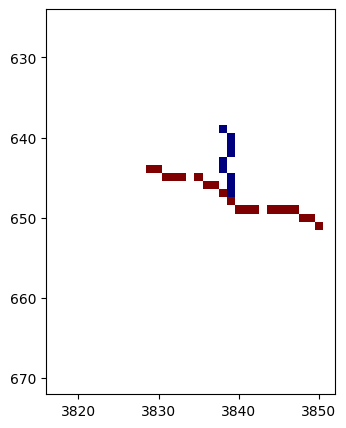

In [147]:
from matplotlib.colors import LinearSegmentedColormap

left = 138
right = 141
bottom = 34
top = 38
#
resolution=12
nx, ny = (right - left)*resolution, (top - bottom)*resolution
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
#
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution
#
edges, riv_path_array = updown(new_basin_to_cities, key_index=0)
tmp = np.ma.masked_where(riv_path_array == 0, riv_path_array)
fig, ax = plt.subplots(figsize=(5,5))
blue_cmap = LinearSegmentedColormap.from_list('blue_cmap', ['#0000FF', '#ADD8E6'])
im = ax.imshow(tmp, cmap='jet')
row_min, row_max = upperindex, lowerindex
col_min, col_max = leftindex, rightindex
ax.set_xlim(col_min, col_max)
ax.set_ylim(row_max, row_min)  # y方向は逆なので注意

plt.show()